In [1]:
!pip install img2dataset
!pip install datasets
!pip install huggingface_hub

     -------------------------------------- 40.6/40.6 kB 644.9 kB/s eta 0:00:00
     ---------------------------------------- 1.8/1.8 MB 2.9 MB/s eta 0:00:00
  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
     ---------------------------------------- 87.7/87.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached opencv_python_headless-4.7.0.72-cp37-abi3-win_amd64.whl (38.1 MB)
     -------------------------------------- 139.5/139.5 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 16.1/16.1 MB 2.6 MB/s eta 0:00:00
     ---------------------------------------- 51.9/51.9 kB 1.3 MB/s eta 0:00:00
  Using cached scipy-1.10.1-cp310-cp310-win_amd64.whl (42.5 MB)
  Using cached PyYAML-6.0-cp310-cp310-win_amd64.whl (151 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
     ---------------------------------------- 22.8/22.8 MB 2.5 MB/s eta 0:00:00
  Using cached ter

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
img2dataset 1.41.0 requires pyarrow<8,>=6.0.1, but you have pyarrow 12.0.0 which is incompatible.


# LAION

In [ ]:
!wget https://huggingface.co/datasets/laion/laion2B-en/resolve/main/part-00000-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet -p /content/LAION/

--2023-06-05 13:49:37--  https://huggingface.co/datasets/laion/laion2B-en/resolve/main/part-00000-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
Resolving huggingface.co (huggingface.co)... 13.249.85.69, 13.249.85.92, 13.249.85.16, ...
Connecting to huggingface.co (huggingface.co)|13.249.85.69|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/datasets/laion/laion2B-en/cc66388dcb64073d6ccd7a957b3a7bf36ad1feb686223b34d35ac137a83f27c7?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27part-00000-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet%3B+filename%3D%22part-00000-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet%22%3B&Expires=1686232177&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL2RhdGFzZXRzL2xhaW9uL2xhaW9uMkItZW4vY2M2NjM4OGRjYjY0MDczZDZjY2Q3YTk1N2IzYTdiZjM2YWQxZmViNjg2MjIzYjM0ZDM1YWMxMzdhODNmMjdjNz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJ

In [ ]:
from datasets import load_dataset
from datasets import Dataset

dataset=load_dataset('/content/huggingface.co', split='train[:1%]')

dataset_train=dataset.train_test_split(10000)['test']

In [ ]:
len(dataset_train)

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import os

# Assuming you already have a datasets.arrow_dataset.Dataset object named 'dataset'

# Convert dataset to Pandas DataFrame
dataframe = dataset_train.to_pandas()

# Save DataFrame as Parquet file
directory = "/content/dataset"
file_name = "dataset.parquet"
os.makedirs(directory, exist_ok=True)

output_path = os.path.join(directory,file_name)

dataframe.to_parquet(output_path)

In [ ]:
!img2dataset --url_list /content/dataset/dataset.parquet --input_format "parquet"\
         --url_col "URL" --caption_col "TEXT" --output_format webdataset\
           --output_folder LAION --processes_count 16 --thread_count 64 \
             --enable_wandb False

In [ ]:
import tarfile
import os
import glob

# Set the path to the folder containing the .tar files
folder_path = "/content/LAION"
output_path = "/content/LAION_Extracted"

# Get a list of all .tar files in the folder
tar_files = glob.glob(os.path.join(folder_path, "*.tar"))

# Iterate over each .tar file and extract its contents
for tar_file_path in tar_files:
    # Extract the .tar file
    with tarfile.open(tar_file_path, "r") as tar:
        tar.extractall(output_path)

print("Extraction complete.")



In [ ]:
import os
import json
from PIL import Image
import datasets
from tqdm import tqdm

# Set the path to the output folder
output_path = "/content/LAION_Extracted"

# Get the list of all .jpg files in the output folder
image_files = sorted([
    filename for filename in os.listdir(output_path)
    if filename.endswith(".jpg")
])

# Create empty lists to store the image and caption data
images = []
captions = []

# Iterate over the image files with tqdm progress bar
for image_file in tqdm(image_files, desc="Loading images"):
    # Get the corresponding JSON file
    json_file = image_file.replace(".jpg", ".json")
    json_path = os.path.join(output_path, json_file)
    
    # Load the JSON content
    with open(json_path, "r") as f:
        json_data = json.load(f)
    
    # Extract the image caption
    caption = json_data["caption"]
    
    # Load the image data
    image_path = os.path.join(output_path, image_file)
    image = Image.open(image_path)
    
    # Add the image and caption to the lists
    images.append(image)
    captions.append(caption)

# Create the dataset using the lists of images and captions
dataset = datasets.Dataset.from_dict({"image": images, "prompt": captions})


Loading images: 100%|██████████| 8222/8222 [00:01<00:00, 6513.01it/s]


In [ ]:
dataset.column_names

['image', 'prompt']

In [ ]:
dataset[:10]['prompt']

['Lovely Electric Walking Sing Unicorn',
 'Two Drawer Night Stand',
 '726-east-23rd-avenue-vancouver-2 at 756 East 23rd Avenue, Fraserview VE, Vancouver East',
 'Annapolis, MD - November 27, 2007 -- Prime Minister Ehud Olmert of Israel, United States President George W. Bush, and President Mahmoud Abbas of the Palestinian Authority share a handshake after Bush read a statement at The Annapolis Conference convened at the United States Naval Academy in Annapolis, Maryland on Tuesday, November 27, 2007..Credit: Ron Sachs / CNP',
 'Cuyahoga Falls resident shoots and kills Akron man he claims was an armed intruder',
 'The endangered Clapper Rail looks for food along the edge of San Francisco Bay. The population levels of the California Clapper Rail are precariously low due to destruction of its coastal habitat by prior land development and shoreline fill.',
 'Hypnosis for Brain Training',
 'witcher2.png',
 'DS 7 Crossback',
 'Hearts on the cupcake,selective focus and valentines day concept'

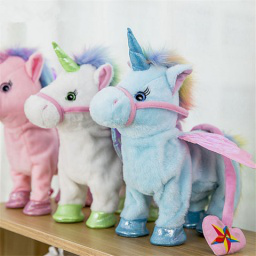

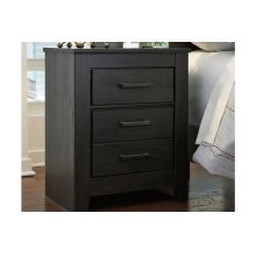

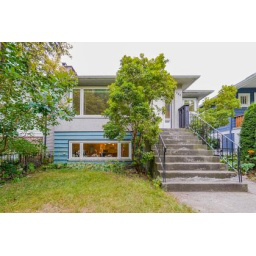

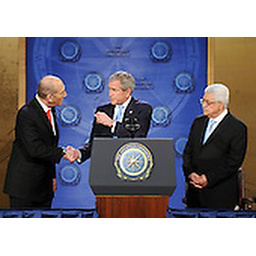

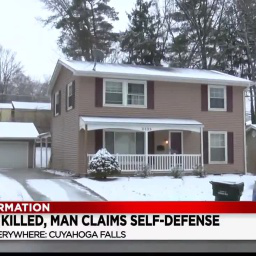

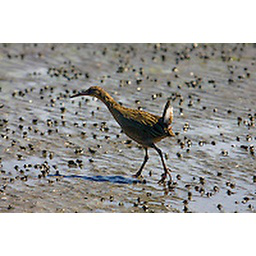

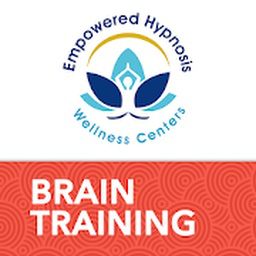

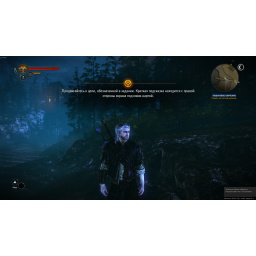

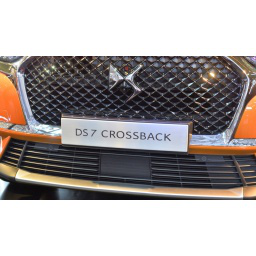

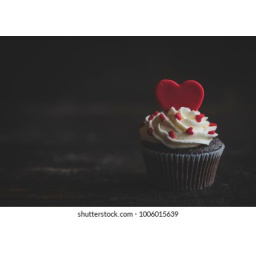

In [ ]:
for image in dataset[:10]['image']:
  image.show()

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
dataset.push_to_hub('wtcherr/LAION10K')

# Unsplash

In [2]:
!wget https://unsplash.com/data/lite/latest -p unsplash

--2023-06-06 04:13:04--  https://unsplash.com/data/lite/latest
Resolving unsplash.com (unsplash.com)... 151.101.193.181, 151.101.1.181, 151.101.129.181, ...
Connecting to unsplash.com (unsplash.com)|151.101.193.181|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip [following]
--2023-06-06 04:13:04--  https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip
Resolving unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)... 52.217.77.252, 54.231.224.217, 52.217.174.209, ...
Connecting to unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)|52.217.77.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 515745615 (492M) [application/zip]
Saving to: 'unsplash.com/data/lite/latest'

     0K .......... .......... .......... .......... ..........  0%  344K 24m24s
    50

In [5]:
!unzip unsplash.com/data/lite/latest -d unsplash_extracted

Archive:  unsplash.com/data/lite/latest
  inflating: unsplash_extracted/colors.tsv000  
  inflating: unsplash_extracted/photos.tsv000  
  inflating: unsplash_extracted/README.md  
  inflating: unsplash_extracted/collections.tsv000  
  inflating: unsplash_extracted/TERMS.md  
  inflating: unsplash_extracted/DOCS.md  
  inflating: unsplash_extracted/keywords.tsv000  
  inflating: unsplash_extracted/conversions.tsv000  


In [6]:
import numpy as np
import pandas as pd
import glob

In [7]:
path = 'unsplash_extracted/'
documents = ['photos']
datasets = {}

for doc in documents:
  files = glob.glob(path + doc + ".tsv*")

  subsets = []
  for filename in files:
    df = pd.read_csv(filename, sep='\t', header=0)
    subsets.append(df)

  datasets[doc] = pd.concat(subsets, axis=0, ignore_index=True)

In [8]:
datasets['photos']

,photo_id,photo_url,photo_image_url,photo_submitted_at,photo_featured,photo_width,photo_height,photo_aspect_ratio,photo_description,photographer_username,...,photo_location_country,photo_location_city,stats_views,stats_downloads,ai_description,ai_primary_landmark_name,ai_primary_landmark_latitude,ai_primary_landmark_longitude,ai_primary_landmark_confidence,blur_hash
0,wud-eV6Vpwo,https://unsplash.com/photos/wud-eV6Vpwo,https://images.unsplash.com/photo-143924685475...,2015-08-10 22:48:30.841999,t,4273,2392,1.79,NaN,sergio_rola,...,NaN,NaN,7515660,42055,silhouette of structure under red sky,NaN,NaN,NaN,NaN,LJMymdi{1IWo}Gj[w^WVICS#bbS2
1,psIMdj26lgw,https://unsplash.com/photos/psIMdj26lgw,https://images.unsplash.com/photo-144077331099...,2015-08-28 14:49:40.016052,t,3872,2176,1.78,NaN,xcvii,...,NaN,NaN,1814817,5893,selective focus photography of black animal ne...,NaN,NaN,NaN,NaN,"LKKd}R^,bJD%~q4Txu%N%gxuD$xu"
2,2EDjes2hlZo,https://unsplash.com/photos/2EDjes2hlZo,https://images.unsplash.com/photo-144683489809...,2015-11-06 18:36:17.334458,t,2560,1707,1.50,Sunset reflection over river,imthinhvu,...,NaN,NaN,2708347,12420,photo of body body of water during golden hour,NaN,NaN,NaN,NaN,LeI{]g9u9u%1?KV@s8R-EAf#t5aL
3,WN8kSLy8KMQ,https://unsplash.com/photos/WN8kSLy8KMQ,https://images.unsplash.com/photo-144530812443...,2015-10-20 02:29:20.267471,t,2288,1520,1.51,Hiking The Mountains,bettenz,...,NaN,NaN,1616448,9773,green leafed trees between two rock formations,Zion National Park,37.250981,-112.950525,65.07215,LoDv=$sjD$bc.AV@ROWCtSn~s:Rj
4,QAXDmkU60OU,https://unsplash.com/photos/QAXDmkU60OU,https://images.unsplash.com/photo-144196149785...,2015-09-11 08:51:54.202624,t,2048,1371,1.49,NaN,j,...,NaN,NaN,983884,9410,landscape photography of snow covered mountain...,NaN,NaN,NaN,NaN,LUIPMT9F%LoIBax]Rkj]Aet7Rjj[
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,eGoU1HxZLUk,https://unsplash.com/photos/eGoU1HxZLUk,https://images.unsplash.com/photo-158796878387...,2020-04-27 06:26:36.451017,t,2250,3000,0.75,NaN,evgenit,...,NaN,NaN,656647,3397,man and woman sitting on bench under starry night,NaN,NaN,NaN,NaN,L98E0oE2W9s.A1%2RjWB0JxaxbR+
24996,V5yz9InMF2s,https://unsplash.com/photos/V5yz9InMF2s,https://images.unsplash.com/photo-157834357269...,2020-01-06 20:47:41.348287,t,4048,3032,1.34,A New Years Eve Walk,mattseymour,...,NaN,NaN,430129,1055,green bare tree field under a calm blue sky,NaN,NaN,NaN,NaN,LwF6zyWBR*j[cbfQoLa|E4j[oefR
24997,6fgxP1VrXwA,https://unsplash.com/photos/6fgxP1VrXwA,https://images.unsplash.com/photo-158080309856...,2020-02-04 08:00:59.364894,t,6048,4024,1.50,NaN,kirklai,...,NaN,NaN,492527,1343,white and yellow flowers in tilt shift lens,NaN,NaN,NaN,NaN,LBDJ9VStIqIA~V-pIVIVD%V[ozj[
24998,cZR7HvWy_ms,https://unsplash.com/photos/cZR7HvWy_ms,https://images.unsplash.com/photo-158906166530...,2020-05-09 22:01:07.784002,t,2962,3702,0.80,Ottawa Tulip’s Festival,marcojodoin,...,NaN,NaN,478320,2134,pink tulip in bloom close up photo,NaN,NaN,NaN,NaN,L57J|g$+0x57#BRjOmSz0eI.=y=z


In [9]:
datasets['photos'].columns

Index(['photo_id', 'photo_url', 'photo_image_url', 'photo_submitted_at',
       'photo_featured', 'photo_width', 'photo_height', 'photo_aspect_ratio',
       'photo_description', 'photographer_username', 'photographer_first_name',
       'photographer_last_name', 'exif_camera_make', 'exif_camera_model',
       'exif_iso', 'exif_aperture_value', 'exif_focal_length',
       'exif_exposure_time', 'photo_location_name', 'photo_location_latitude',
       'photo_location_longitude', 'photo_location_country',
       'photo_location_city', 'stats_views', 'stats_downloads',
       'ai_description', 'ai_primary_landmark_name',
       'ai_primary_landmark_latitude', 'ai_primary_landmark_longitude',
       'ai_primary_landmark_confidence', 'blur_hash'],
      dtype='object')

In [8]:
datasets['photos']=datasets['photos'][['photo_id', 'photo_image_url', 'photo_width', 'photo_height', 'photo_aspect_ratio', 'ai_description', 'photo_description']]

In [9]:
import os

directory = "/content/dataset"
file_name = "unsplash.parquet"
os.makedirs(directory, exist_ok=True)

output_path = os.path.join(directory,file_name)

datasets['photos'].to_parquet(output_path)

In [ ]:
!img2dataset --url_list /content/dataset/unsplash.parquet --input_format "parquet"\
         --url_col "photo_image_url" --caption_col "ai_description" --output_format parquet\
           --output_folder UNSPLASH --processes_count 16 --thread_count 64 --image_size 512\
             --resize_mode keep_ratio --enable_wandb False

Starting the downloading of this file
Sharding file number 1 of 1 called /content/dataset/unsplash.parquet
0it [00:00, ?it/s]File sharded in 3 shards
